In [4]:
import os
os.getcwd()

'/gpfs/home/thomased/work/codebase/coopsummer2023/Project/notebooks'

In [5]:
doc_path = '/home/thomased/work/codebase/coopsummer2023/UniKP/UniKeyphrase/processed/kp20k.test.seq.in'
doc_label_path = '/home/thomased/work/codebase/coopsummer2023/UniKP/UniKeyphrase/processed/kp20k.test.seq.out'
doc_abs_path = '/home/thomased/work/codebase/coopsummer2023/UniKP/UniKeyphrase/processed/kp20k.test.absent'

In [6]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
from tqdm import tqdm

with open(doc_path, 'r') as f, open(doc_label_path, 'r') as f1:
    lines, lines1 = f.readlines(), f1.readlines()
    all_ex_kps = []
    for (doc, label) in tqdm(zip(lines, lines1), total=len(lines)):
        doc_list = ['[CLS]']+doc.strip().split(" ")+['[SEP]']
        label_list = ['O']+label.strip().split(" ")+['O']
        # convert tokens to ids
        ids = tokenizer.convert_tokens_to_ids(doc_list)
        assert len(ids)==len(label_list), '# doc tokens not equal to # of labels'
        
        ex_kps = {} # key: Ex KP , value: [start_ind, end_ind] of tokens of all words in that key phrase
        # get the KP spans
        ex_kp, start = '', -1

        for ind, doc_label in enumerate(label_list):
            word = doc_list[ind]
            if doc_label == 'B':
                start = ind
                ex_kp+= word
            elif doc_label in ['X','I']: # sub-word or inside kp
                if word.startswith('##'):
                    ex_kp+=word.lstrip('##')
                else: #new word, append with space
                    ex_kp+=' '+word
            elif doc_label == 'O' and start!=-1:
                # record the token span
                ex_kps[ex_kp] = ex_kps.setdefault(ex_kp, [])+[[start, ind]]
                ex_kp, start = '', -1 # reset ex_kp and start
        
        # if last kp extends till end
        if doc_label != 'O':
            ex_kps[ex_kp] = ex_kps.setdefault(ex_kp, [])+[[start, ind]]
                
        
        
        all_ex_kps.append(ex_kps)  
        # break

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 19987/19987 [00:04<00:00, 4645.53it/s]


In [9]:
# processing abstractive tokens
# append to end of the sentence after SEP token
all_ab_kps = []
all_inp_tokens = []
with open(doc_abs_path, 'r') as f:
    abs_lines = f.readlines()
    for doc_line, line in zip(lines, abs_lines):
        doc_line_list = ['[CLS]']+doc_line.strip().split(" ")+['[SEP]']
        ab_line_list = line.strip().split(" ") + ['[SEP]']
        
        offset = len(doc_line_list)
        ab_kp = {}
        start, ab_word = 0, '' 
        for ind, tok in enumerate(ab_line_list):
            if tok == ';':
                ab_kp[ab_word] = ab_kp.setdefault(ab_word, [])+[[start+offset,ind+offset]]
                start, ab_word = ind+1, ''
            elif tok != '[SEP]':
                if tok.startswith('##'):
                    ab_word+=tok.lstrip('##')
                else:
                    ab_word+=' '+tok
                    
        # add final kp
        ab_kp[ab_word] = ab_kp.setdefault(ab_word, [])+[[start+offset, ind+offset]]
        
        all_ab_kps.append(ab_kp)
        
        # update lines
        doc_line_list = doc_line_list + ab_line_list
        all_inp_tokens.append(doc_line_list)

In [10]:
# verification (test code for absent key-phrase)
check_ind = 0
for key in all_ab_kps[check_ind]:
    for start, end in all_ab_kps[check_ind][key]:
        print(start, end)
        print('key: ',key, 'inp_tokens', all_inp_tokens[check_ind][start:end])

157 162
key:   decycling set inp_tokens ['de', '##cy', '##c', '##ling', 'set']


In [11]:
# verify the ex_kps dict construction (test code)
check_ind = 0
for key in all_ex_kps[check_ind]:
    print('\n',key)
    for start, end in all_ex_kps[check_ind][key]:
        print(all_inp_tokens[check_ind][start:end])


 feedback vertex set
['feedback', 'vertex', 'set']
['feedback', 'vertex', 'set']
['feedback', 'vertex', 'set']
['feedback', 'vertex', 'set']

 2 degenerate graphs
['2', 'de', '##generate', 'graphs']


In [12]:
# get the bert embeddings for each doc and analyze closeness
from transformers import BertModel
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Input Tokens:  ['[CLS]', 'a', 'feedback', 'vertex', 'set', 'of', '2', 'de', '##generate', 'graphs', '.', 'a', 'feedback', 'vertex', 'set', 'of', 'a', 'graph', 'g', 'is', 'a', 'set', 's', 'of', 'its', 'vertices', 'such', 'that', 'the', 'sub', '##graph', 'induced', 'by', 'v', '(', 'g', ')', 's', 'is', 'a', 'forest', '.', 'the', 'cardinal', '##ity', 'of', 'a', 'minimum', 'feedback', 'vertex', 'set', 'of', 'g', 'is', 'denoted', 'by', '(', 'g', ')', '.', 'a', 'graph', 'g', 'is', '2', 'de', '##generate', 'if', 'each', 'sub', '##graph', 'g', 'of', 'g', 'has', 'a', 'vertex', 'v', 'such', 'that', 'd', '##g', '(', 'v', ')', '2', '.', 'in', 'this', 'paper', ',', 'we', 'prove', 'that', '(', 'g', ')', '2', '##n', '5', 'for', 'any', '2', 'de', '##generate', 'n', 'vertex', 'graph', 'g', 'and', 'more', '##over', ',', 'we', 'show', 'that', 'this', 'bound', 'is', 'tight', '.', 'as', 'a', 'consequence', ',', 'we', 'derive', 'a', 'polynomial', 'time', 'algorithm', ',', 'which', 'for', 'a', 'given', '2', '

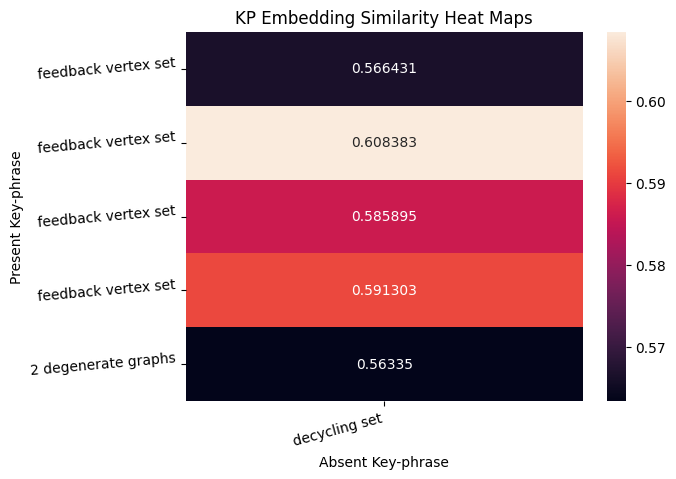

Input Tokens:  ['[CLS]', 'hybrid', 'analytical', 'modeling', 'of', 'pending', 'cache', 'hits', ',', 'data', 'pre', '##fe', '##tch', '##ing', ',', 'and', 'm', '##sh', '##rs', '.', 'this', 'article', 'proposes', 'techniques', 'to', 'predict', 'the', 'performance', 'impact', 'of', 'pending', 'cache', 'hits', ',', 'hardware', 'pre', '##fe', '##tch', '##ing', ',', 'and', 'miss', 'status', 'holding', 'register', 'resources', 'on', 'super', '##sca', '##lar', 'micro', '##p', '##ro', '##cess', '##ors', 'using', 'hybrid', 'analytical', 'models', '.', 'the', 'proposed', 'models', 'focus', 'on', 'timeline', '##ss', 'of', 'pending', 'hit', 's', 'and', 'pre', '##fe', '##tches', 'and', 'account', 'for', 'a', 'limited', 'number', 'of', 'm', '##sh', '##rs', '.', 'they', 'improve', 'modeling', 'accuracy', 'of', 'pending', 'hit', 's', 'by', '3', '.', '9', '##x', 'and', 'when', 'modeling', 'data', 'pre', '##fe', '##tch', '##ing', ',', 'a', 'limited', 'number', 'of', 'm', '##sh', '##rs', ',', 'or', 'both',

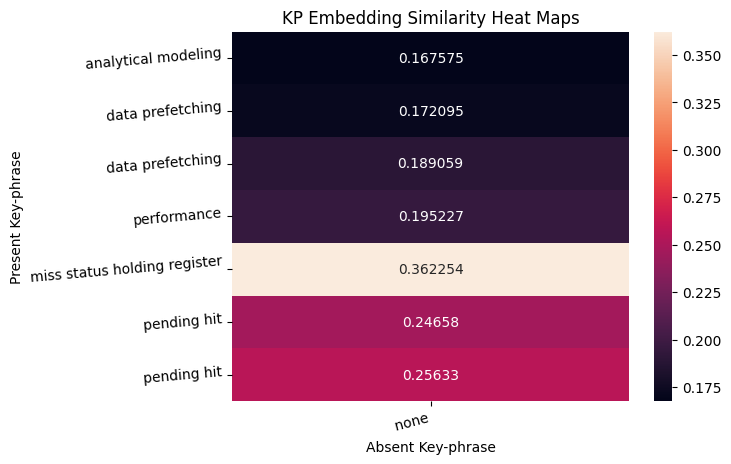

Input Tokens:  ['[CLS]', 'auto', '##im', '##mu', '##ne', 'p', '##oly', '##end', '##oc', '##rino', '##pathy', 'can', '##di', '##dia', '##sis', 'e', '##ct', '##ode', '##rmal', 'd', '##ys', '##tro', '##phy', 'known', 'and', 'novel', 'aspects', 'of', 'the', 'syndrome', '.', 'auto', '##im', '##mu', '##ne', 'p', '##oly', '##end', '##oc', '##rino', '##pathy', 'can', '##di', '##dia', '##sis', 'e', '##ct', '##ode', '##rmal', 'd', '##ys', '##tro', '##phy', '(', 'a', '##pec', '##ed', ')', 'is', 'a', 'mon', '##ogenic', 'auto', '##so', '##mal', 're', '##cess', '##ive', 'disease', 'caused', 'by', 'mutations', 'in', 'the', 'auto', '##im', '##mu', '##ne', 'regulator', '(', 'air', '##e', ')', 'gene', 'and', ',', 'as', 'a', 'syndrome', ',', 'is', 'characterized', 'by', 'chronic', 'm', '##uc', '##oc', '##uta', '##ne', '##ous', 'can', '##di', '##dia', '##sis', 'and', 'the', 'presentation', 'of', 'various', 'auto', '##im', '##mu', '##ne', 'diseases', '.', 'during', 'the', 'last', 'decade', ',', 'research',

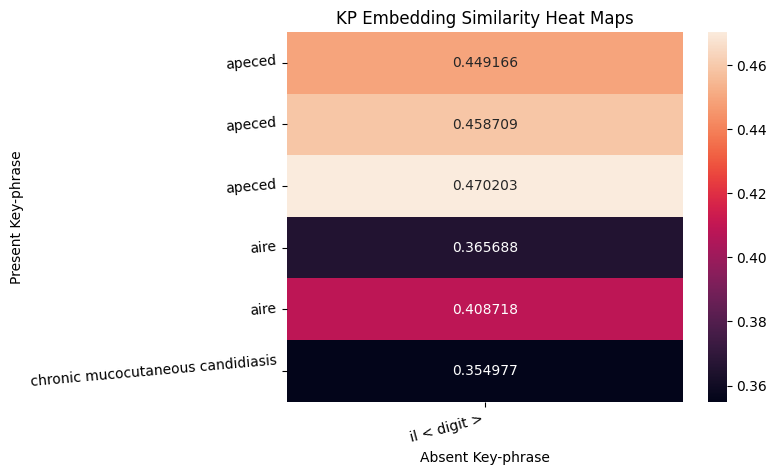

Input Tokens:  ['[CLS]', 'numerical', 'solution', 'of', 'a', 'three', 'dimensional', 'solid', '##ification', 'problem', 'in', 'aluminium', 'casting', '.', 'in', 'this', 'paper', ',', 'we', 'consider', 'an', 'en', '##thal', '##py', 'formulation', 'for', 'a', 'two', 'phase', 's', '##te', '##fan', 'problem', 'arising', 'from', 'the', 'solid', '##ification', 'of', 'aluminium', 'during', 'casting', 'process', '.', 'we', 'solve', 'this', 'free', 'boundary', 'problem', 'in', 'a', 'time', 'varying', 'three', 'dimensional', 'domain', 'and', 'consider', 'con', '##ve', '##ctive', 'heat', 'transfer', 'in', 'the', 'liquid', 'phase', '.', 'the', 'resulting', 'equations', 'are', 'disc', '##ret', '##ized', 'using', 'a', 'characteristics', 'method', 'in', 'time', 'and', 'a', 'finite', 'element', 'method', 'in', 'space', ',', 'and', 'we', 'propose', 'a', 'numerical', 'algorithm', 'to', 'solve', 'the', 'obtained', 'non', '##linear', 'disc', '##ret', '##ized', 'problem', '.', 'finally', ',', 'numerical', 

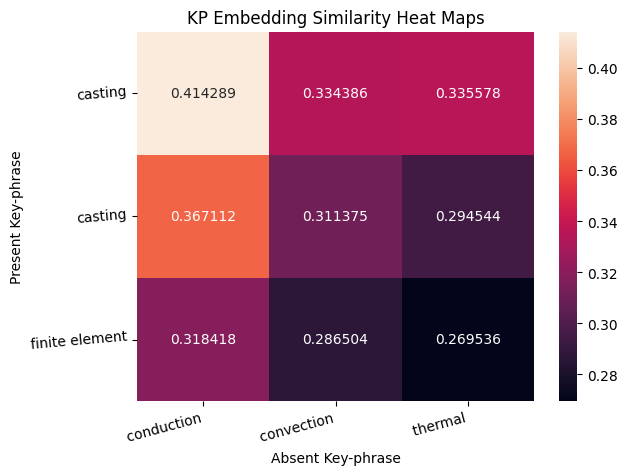

Input Tokens:  ['[CLS]', 'definition', 'and', 'recognition', 'of', 'rib', 'features', 'in', 'aircraft', 'structural', 'part', '.', 'in', 'this', 'research', ',', 'a', 'new', 'type', 'of', 'manufacturing', 'feature', 'that', 'is', 'commonly', 'observed', 'in', 'aircraft', 'structural', 'part', 's', ',', 'known', 'as', 'rib', 's', ',', 'is', 'defined', 'and', 'implemented', 'using', 'the', 'object', 'oriented', 'software', 'engineering', 'approach', '.', 'the', 'rib', 'feature', 'type', 'is', 'defined', 'as', 'a', 'set', 'of', 'con', '##stra', '##ined', 'and', 'adjacent', 'faces', 'of', 'a', 'part', 'which', 'are', 'associated', 'with', 'a', 'set', 'of', 'specific', 'rib', 'mac', '##hin', '##ing', 'operations', '.', 'computer', '##ized', 'numerical', 'control', '(', 'c', '##nc', ')', 'operation', 'experience', 'and', 'the', 'mac', '##hin', '##ing', 'knowledge', 'are', 'leverage', '##d', 'by', 'anal', '##ys', '##ing', 'typical', 'geometry', 'interactions', 'when', 'generating', 'mac', '##

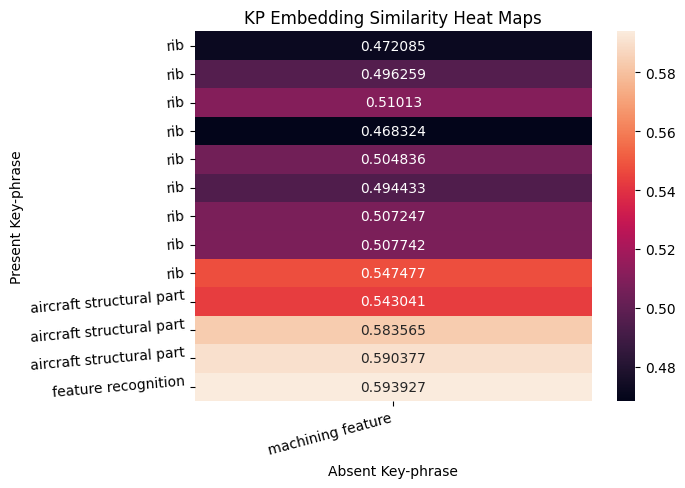

Input Tokens:  ['[CLS]', 'an', 'algebraic', 'approach', 'to', 'guarantee', 'harmonic', 'balance', 'method', 'using', 'g', '##ro', '##bner', 'base', '.', 'harmonic', 'balance', '(', 'h', '##b', ')', 'method', 'is', 'well', 'known', 'principle', 'for', 'analyzing', 'periodic', 'o', '##s', '##cilla', '##tions', 'on', 'non', '##linear', 'networks', 'and', 'systems', '.', 'because', 'the', 'h', '##b', 'method', 'has', 'a', 't', '##run', '##cation', 'error', ',', 'approximate', '##d', 'solutions', 'have', 'been', 'guaranteed', 'by', 'error', 'bound', 's', '.', 'however', ',', 'its', 'numerical', 'com', '##putation', 'is', 'very', 'time', 'consuming', 'compared', 'with', 'solving', 'the', 'h', '##b', 'equation', '.', 'this', 'paper', 'proposes', 'an', 'algebraic', 'representation', 'of', 'the', 'error', 'bound', 'using', 'g', '##ro', '##bner', 'base', '.', 'the', 'algebraic', 'representation', 'enables', 'to', 'decrease', 'the', 'computational', 'cost', 'of', 'the', 'error', 'bound', 'conside

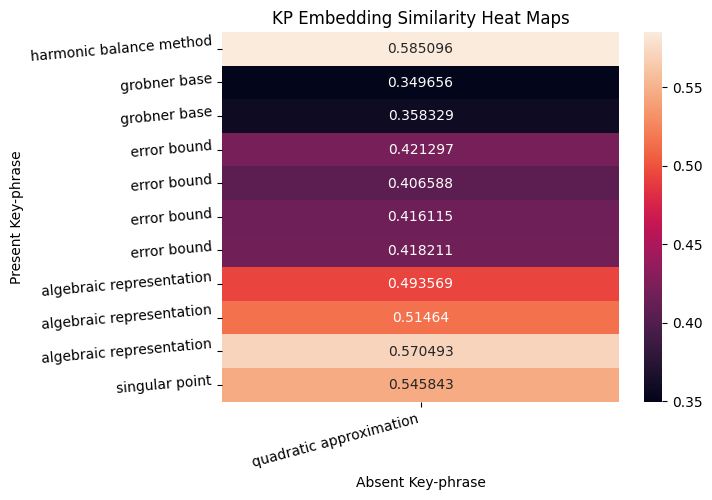

Input Tokens:  ['[CLS]', 'a', 'graph', 'coloring', 'based', 't', '##d', '##ma', 'scheduling', 'algorithm', 'for', 'wireless', 'sensor', 'networks', '.', 'wireless', 'sensor', 'networks', 'should', 'provide', 'with', 'valuable', 'service', ',', 'which', 'is', 'called', 'service', 'oriented', 'requirement', '.', 'to', 'meet', 'this', 'need', ',', 'a', 'novel', 'distributed', 'graph', 'coloring', 'based', 'time', 'division', 'multiple', 'access', 'scheduling', 'algorithm', '(', 'g', '##cs', '##a', ')', ',', 'considering', 'real', 'time', 'performance', 'for', 'cluster', '##ing', 'based', 'sensor', 'network', ',', 'is', 'proposed', 'in', 'this', 'paper', ',', 'to', 'determine', 'the', 'smallest', 'length', 'of', 'conflict', 'free', 'assignment', 'of', 'times', '##lot', '##s', 'for', 'in', '##tra', 'cluster', 'transmissions', '.', 'g', '##cs', '##a', 'involves', 'two', 'phases', '.', 'in', 'coloring', 'phase', ',', 'networks', 'are', 'modeled', 'using', 'graph', 'theory', ',', 'and', 'a', '

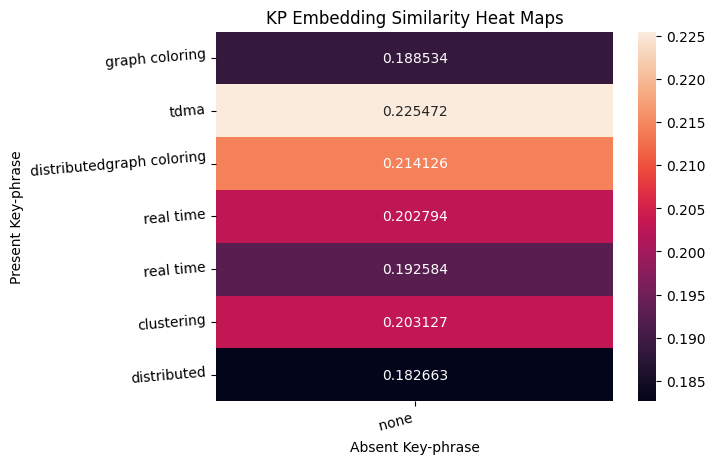

Input Tokens:  ['[CLS]', 'shot', 'change', 'detection', 'using', 'scene', 'based', 'con', '##stra', '##int', '.', 'a', 'key', 'step', 'for', 'managing', 'a', 'large', 'video', 'database', 'is', 'to', 'partition', 'the', 'video', 'sequences', 'into', 'shots', '.', 'past', 'approaches', 'to', 'this', 'problem', 'tend', 'to', 'con', '##fuse', 'gradual', 'shot', 'changes', 'with', 'changes', 'caused', 'by', 'smooth', 'camera', 'motions', '.', 'this', 'is', 'in', 'part', 'due', 'to', 'the', 'fact', 'that', 'camera', 'motion', 'has', 'not', 'been', 'dealt', 'with', 'in', 'a', 'more', 'fundamental', 'way', '.', 'we', 'propose', 'an', 'approach', 'that', 'is', 'based', 'on', 'a', 'physical', 'con', '##stra', '##int', 'used', 'in', 'optical', 'flow', 'analysis', ',', 'namely', ',', 'the', 'total', 'brightness', 'of', 'a', 'scene', 'point', 'across', 'two', 'frames', 'should', 'remain', 'constant', 'if', 'the', 'change', 'across', 'two', 'frames', 'is', 'a', 'result', 'of', 'smooth', 'camera', '

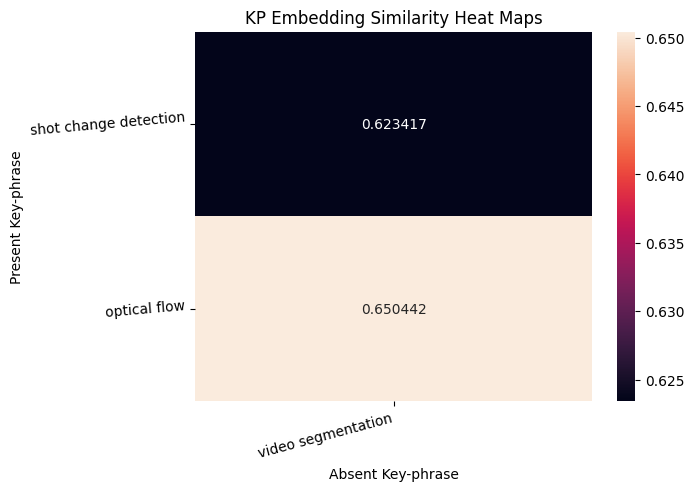

Input Tokens:  ['[CLS]', 'tail', 'as', '##ym', '##pt', '##otics', 'for', 'ho', '##l', 'priority', 'que', '##ues', 'handling', 'a', 'large', 'number', 'of', 'independent', 'stationary', 'sources', '.', 'in', 'this', 'paper', 'we', 'study', 'the', 'as', '##ym', '##pt', '##otics', 'of', 'the', 'tail', 'of', 'the', 'buffer', 'o', '##cc', '##up', '##ancy', 'distribution', 'in', 'buffer', '##s', 'accessed', 'by', 'a', 'large', 'number', 'of', 'stationary', 'independent', 'sources', 'and', 'which', 'are', 'served', 'according', 'to', 'a', 'strict', 'ho', '##l', 'priority', 'rule', '.', 'as', 'in', 'the', 'case', 'of', 'single', 'buffer', '##s', ',', 'the', 'results', 'are', 'valid', 'for', 'a', 'very', 'general', 'class', 'of', 'sources', 'which', 'include', 'long', 'range', 'dependent', 'sources', 'with', 'bounded', 'instant', '##aneous', 'rates', '.', 'we', 'first', 'consider', 'the', 'case', 'of', 'two', 'buffer', '##s', 'with', 'one', 'of', 'them', 'having', 'strict', 'priority', 'over', 

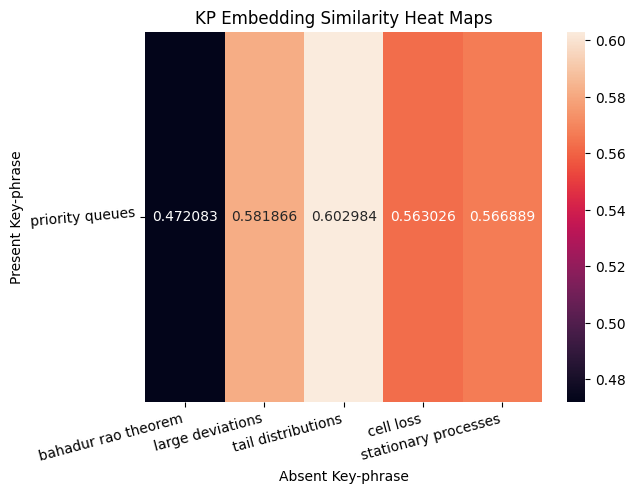

Input Tokens:  ['[CLS]', 'a', 'variant', 'of', 'parallel', 'plane', 'sweep', 'algorithm', 'for', 'multi', '##core', 'systems', '.', 'parallel', 'algorithms', 'used', 'in', 'very', 'large', 'scale', 'integration', 'physical', 'design', 'bring', 'significant', 'challenges', 'for', 'their', 'efficient', 'and', 'effective', 'design', 'and', 'implementation', '.', 'the', 're', '##ct', '##ang', '##le', 'intersection', 'problem', 'is', 'a', 'subset', 'of', 'the', 'plane', 'sweep', 'problem', ',', 'a', 'topic', 'of', 'computational', 'geometry', 'and', 'a', 'component', 'in', 'design', 'rule', 'checking', ',', 'para', '##sitic', 'resistance', 'cap', '##ac', '##ita', '##nce', 'extraction', ',', 'and', 'mask', 'processing', 'flows', '.', 'a', 'variant', 'of', 'a', 'plane', 'sweep', 'algorithm', 'that', 'is', 'embarrassing', '##ly', 'parallel', 'and', 'therefore', 'easily', 's', '##cal', '##able', 'on', 'multi', '##core', 'machines', 'and', 'clusters', ',', 'while', 'exceeding', 'the', 'best', 'k

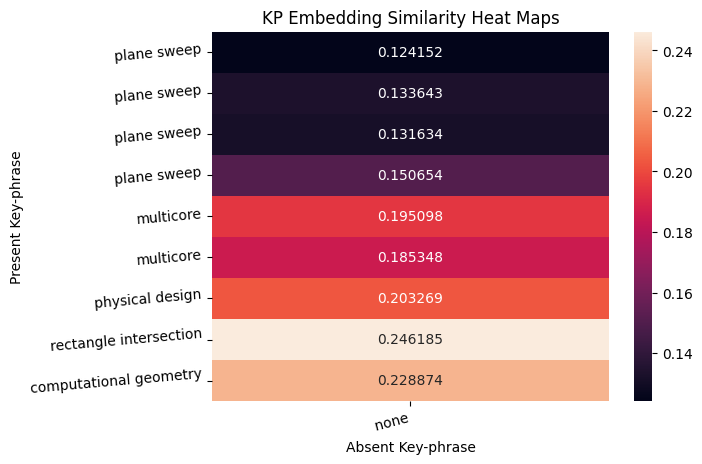

Input Tokens:  ['[CLS]', 'the', 'ant', '##ec', '##ede', '##nts', 'and', 'con', '##se', '##quent', '##s', 'of', 'user', 'perception', '##s', 'in', 'information', 'technology', 'adoption', '.', 'a', 'common', 'theme', 'underlying', 'various', 'models', 'that', 'explain', 'information', 'technology', 'adoption', 'is', 'the', 'inclusion', 'of', 'perception', '##s', 'of', 'an', 'innovation', 'as', 'key', 'independent', 'variables', '.', 'although', 'a', 'fairly', 'significant', 'body', 'of', 'research', 'that', 'empirical', '##ly', 'tests', 'these', 'models', 'is', 'now', 'in', 'existence', ',', 'some', 'questions', 'with', 'regard', 'to', 'both', 'the', 'ant', '##ec', '##ede', '##nts', 'as', 'well', 'as', 'the', 'con', '##se', '##quent', '##s', 'of', 'perception', '##s', 'remain', 'un', '##ans', '##wer', '##ed', '.', 'this', 'paper', 'reports', 'the', 'results', 'of', 'a', 'field', 'study', 'examining', 'adoption', 'of', 'an', 'information', 'technology', 'innovation', 'represented', 'by',

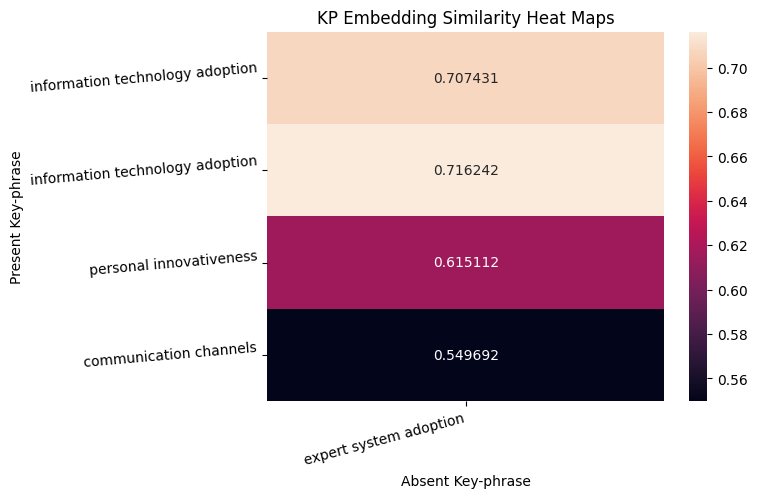

Input Tokens:  ['[CLS]', 'improving', 'classification', 'with', 'late', '##nt', 'variable', 'models', 'by', 'se', '##quential', 'con', '##stra', '##int', 'optimization', '.', 'in', 'this', 'paper', 'we', 'propose', 'a', 'method', 'to', 'use', 'multiple', 'genera', '##tive', 'models', 'with', 'late', '##nt', 'variables', 'for', 'classification', 'tasks', '.', 'the', 'standard', 'approach', 'to', 'use', 'genera', '##tive', 'models', 'for', 'classification', 'is', 'to', 'train', 'a', 'separate', 'model', 'for', 'each', 'class', '.', 'a', 'novel', 'data', 'point', 'is', 'then', 'classified', 'by', 'the', 'model', 'that', 'attributes', 'the', 'highest', 'probability', '.', 'the', 'algorithm', 'we', 'propose', 'm', '##od', '##ifies', 'the', 'parameters', 'of', 'the', 'models', 'to', 'improve', 'the', 'classification', 'accuracy', '.', 'our', 'approach', 'is', 'made', 'computational', '##ly', 'tract', '##able', 'by', 'assuming', 'that', 'each', 'of', 'the', 'models', 'is', 'de', '##ter', '##m

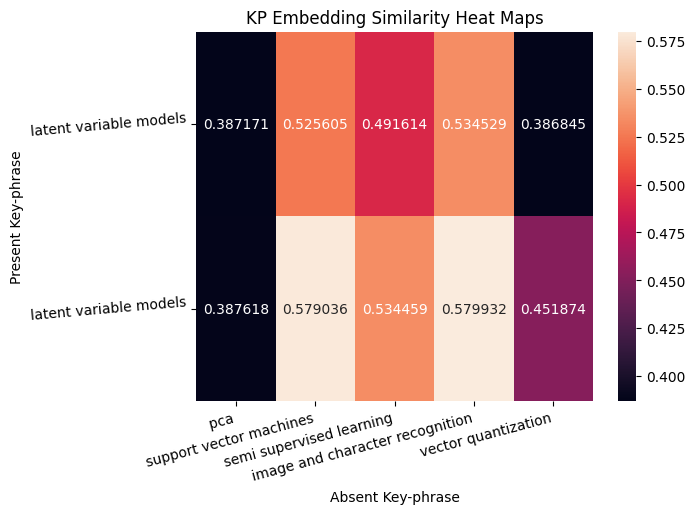

Input Tokens:  ['[CLS]', 'a', 'framework', 'for', 'a', 'real', 'time', 'intelligent', 'and', 'interactive', 'brain', 'computer', 'interface', '.', 'a', 'framework', 'for', 'a', 'real', 'time', 'implementation', 'of', 'a', 'brain', 'computer', 'interface', '.', 'implementation', '&', 'comparison', 'of', 'different', 'feature', 'extraction', 'methods', 'and', 'class', '##ifier', '##s', '.', 'accuracy', '&', 'processing', 'time', 'comparison', 'for', 'detection', 'of', 'event', 'related', 'potential', '##s', 'er', '##p', '.', 'an', 'implementation', 'of', 'a', 'prototype', 'system', 'using', 'the', 'proposed', 'b', '##ci', 'framework', '.', 'real', 'time', 'e', '##eg', 'data', 'collection', 'and', 'classification', 'of', 'er', '##ps', 'using', 'he', '##x', 'o', 'spell', '##er', '.', '[SEP]', 'electro', '##ence', '##pha', '##log', '##raphy', ';', 'brain', '##com', '##pute', '##r', 'interface', '[SEP]']


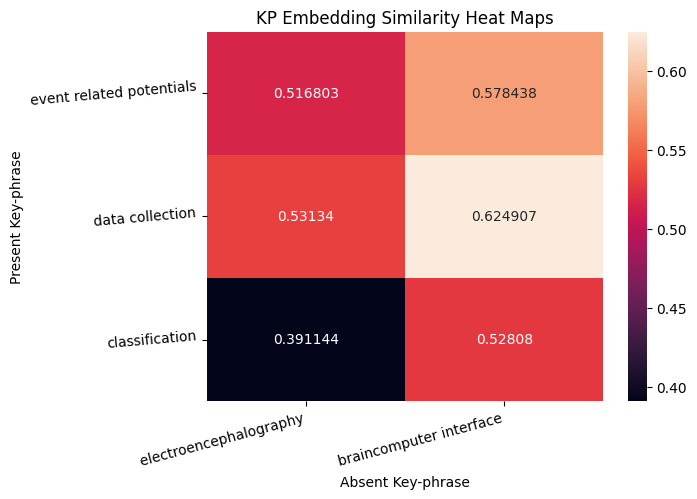

Input Tokens:  ['[CLS]', 'character', '##izing', 'output', 'processes', 'of', 'e', 'm', 'e', 'k', '1', 'que', '##ues', '.', 'our', 'goal', 'is', 'to', 'study', 'which', 'conditions', 'of', 'the', 'output', 'process', 'of', 'a', 'que', '##ue', 'preserve', 'the', 'increasing', 'failure', 'rate', '(', 'if', '##r', ')', 'property', 'in', 'the', 'inter', '##de', '##par', '##ture', 'time', '.', 'we', 'found', 'that', 'the', 'inter', '##de', '##par', '##ture', 'time', 'does', 'not', 'always', 'preserve', 'the', 'if', '##r', 'property', ',', 'even', 'if', 'the', 'inter', '##ar', '##ri', '##val', 'time', 'and', 'service', 'time', 'are', 'both', 'er', '##lang', 'distribution', 's', 'with', 'if', '##r', '.', 'we', 'give', 'a', 'theoretical', 'analysis', 'and', 'present', 'numerical', 'results', 'of', 'e', 'm', 'e', 'k', '1', 'que', '##ues', '.', 'we', 'show', ',', 'by', 'numerical', 'examples', ',', 'that', 'the', 'inter', '##de', '##par', '##ture', 'time', 'of', 'e', 'm', 'e', 'k', '1', 'retains

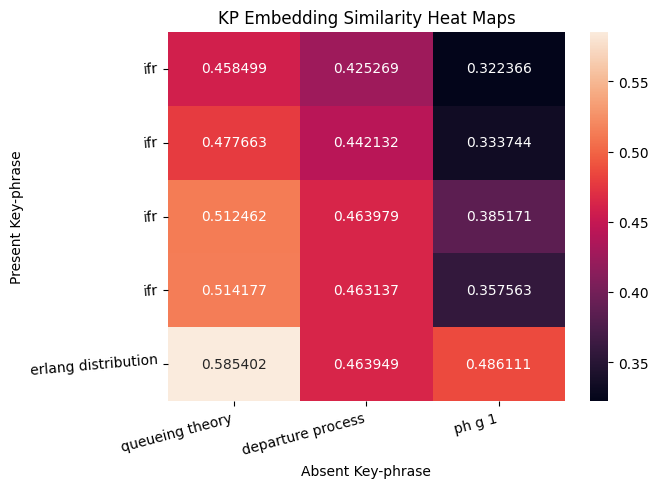

Input Tokens:  ['[CLS]', 'a', 'low', 'complexity', 'down', 'mixing', 'structure', 'on', 'q', '##uad', '##rap', '##hon', '##ic', 'heads', '##ets', 'for', 'surround', 'audio', '.', 'this', 'work', 'presents', 'a', 'four', 'channel', 'heads', '##et', 'achieving', 'a', '5', '.', '1', 'channel', 'like', 'hearing', 'experience', 'using', 'a', 'low', 'complexity', 'head', 'related', 'transfer', 'function', '(', 'h', '##rt', '##f', ')', 'model', 'and', 'a', 'simplified', 're', '##ver', '##ber', '##ator', '.', 'the', 'proposed', 'down', 'mixing', 'architecture', 'enhance', '##s', 'the', 'sound', 'local', '##ization', 'capability', 'of', 'a', 'heads', '##et', 'using', 'the', 'h', '##rt', '##f', 'and', 'by', 'si', '##mulating', 'multiple', 'sound', 'reflections', 'in', 'a', 'room', 'using', 'm', '##oor', '##er', "'", 's', 're', '##ver', '##ber', '##ator', '.', 'since', 'the', 'h', '##rt', '##f', 'has', 'large', 'memory', 'and', 'com', '##putation', 'requirements', ',', 'the', 'common', 'acoustic'

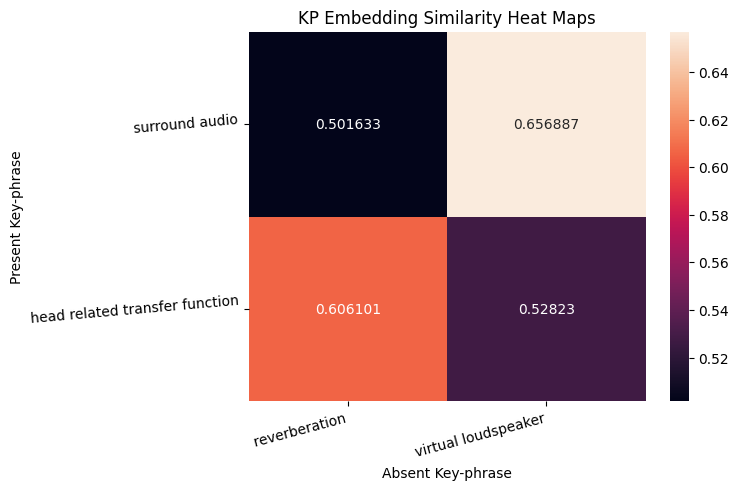

Input Tokens:  ['[CLS]', 'security', 'personal', '##ization', 'for', 'internet', 'and', 'web', 'services', '.', 'the', 'growth', 'of', 'the', 'internet', 'has', 'been', 'accompanied', 'by', 'the', 'growth', 'of', 'internet', 'services', '(', 'e', '.', 'g', '.', ',', 'e', 'commerce', ',', 'e', 'health', ')', '.', 'this', 'proliferation', 'of', 'services', 'and', 'the', 'increasing', 'attacks', 'on', 'them', 'by', 'ma', '##lic', '##ious', 'individuals', 'have', 'highlighted', 'the', 'need', 'for', 'service', 'security', '.', 'the', 'security', 'requirements', 'of', 'an', 'internet', 'or', 'p', '##le', '##b', 'service', 'may', 'be', 'specified', 'in', 'a', 'security', 'policy', '.', 'the', 'provider', 'of', 'the', 'service', 'is', 'then', 'responsible', '.', ',', 'for', 'implementing', 'the', 'security', 'measures', 'contained', 'in', 'the', 'policy', '.', 'however', ',', 'a', 'service', 'customer', 'or', 'consumer', 'may', 'have', 'security', 'preferences', 'that', 'are', 'not', 'reflect

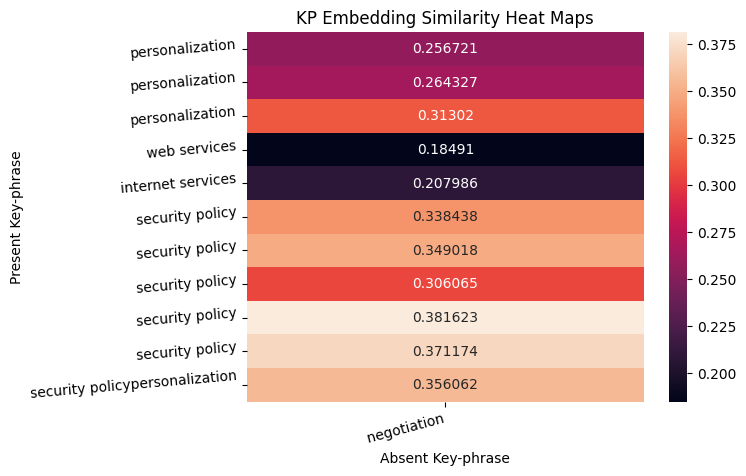

Input Tokens:  ['[CLS]', 'two', 'efficient', 's', '##ync', '##hr', '##ono', '##us', 'double', 'left', 'right', 'arrow', 'as', '##ync', '##hr', '##ono', '##us', 'convert', '##ers', 'well', 'suited', 'for', 'networks', 'on', 'chip', 'in', 'gal', '##s', 'architecture', '##s', '.', 'this', 'paper', 'presents', 'two', 'high', 'through', '##put', ',', 'low', 'late', '##ncy', 'convert', '##ers', 'that', 'can', 'be', 'used', 'to', 'convert', 's', '##ync', '##hr', '##ono', '##us', 'communication', 'protocol', 'to', 'as', '##ync', '##hr', '##ono', '##us', 'one', 'and', 'vice', 'versa', '.', 'we', 'have', 'designed', 'these', 'two', 'hardware', 'components', 'to', 'be', 'used', 'in', 'a', 'globally', 'as', '##ync', '##hr', '##ono', '##us', 'locally', 's', '##ync', '##hr', '##ono', '##us', 'cluster', '##ized', 'multi', 'processor', 'system', 'on', 'chip', 'communicating', 'by', 'a', 'fully', 'as', '##ync', '##hr', '##ono', '##us', 'network', 'on', 'chip', '.', 'the', 'proposed', 'architecture', 'i

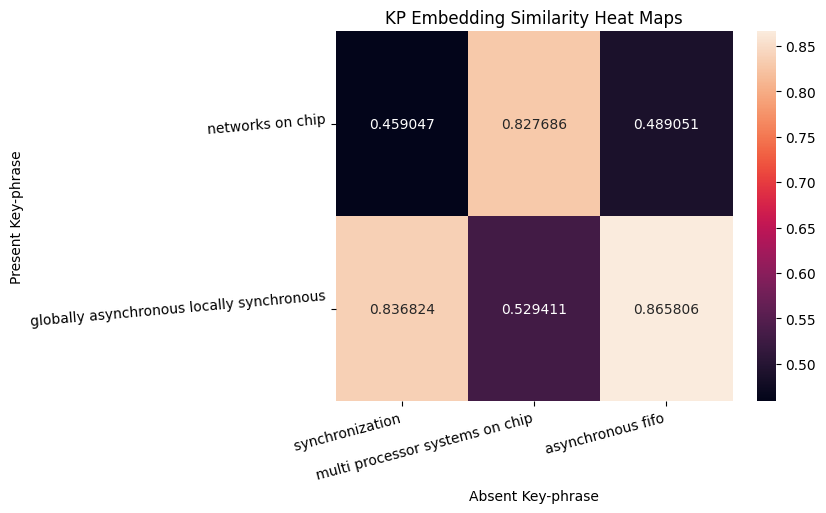

Input Tokens:  ['[CLS]', 'explicit', 'constructions', 'of', 'select', '##ors', 'and', 'related', 'comb', '##inator', '##ial', 'structures', ',', 'with', 'applications', '.', 'in', 'this', 'paper', 'we', 'present', 'explicit', 'constructions', 'of', 'several', 'comb', '##inator', '##ial', 'object', 's', 'select', '##ors', 'c', '##g', '##r', '##00', 'and', 'selective', 'families', 'c', '##gg', '##p', '##r', '##00', ',', 'pseudo', 'random', 'generators', 'for', 'proof', 'systems', 'a', '##b', '##r', '##w', '##00', 'and', 'fixed', 'waking', 'schedules', 'g', '##pp', '##00', '.', 'as', 'a', 'result', ',', 'we', 'obtain', 'almost', 'optimal', 'de', '##ter', '##mini', '##stic', 'protocols', 'for', 'broadcasting', 'in', 'unknown', 'direct', 'ed', 'radio', 'networks', 'c', '##g', '##r', '##00', 'and', 'wake', 'up', 'problem', 'g', '##pp', '##00', '.', 'we', 'also', 'show', 'application', 'of', 'select', '##ors', '(', 'and', 'its', 'variants', ')', 'to', 'explicit', 'construction', 'of', 'test',

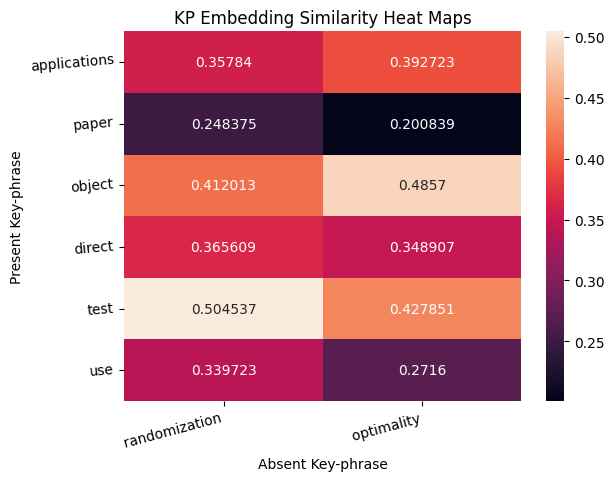

Input Tokens:  ['[CLS]', 'selective', 'finite', 'element', 're', '##fine', '##ment', 'in', 'to', '##rs', '##ion', 'al', 'problems', 'based', 'on', 'the', 'membrane', 'analogy', '.', 'this', 'work', 'presents', 'a', 'selective', 'finite', 'element', 're', '##fine', '##ment', 'strategy', 'based', 'on', 'the', 'h', 're', '##fine', '##ment', 'type', ',', 'in', 'the', 'context', 'of', 'a', 'posterior', '##i', 'error', 'estimates', 'considerations', '(', 'error', 'com', '##puted', 'after', 'the', 'application', 'of', 'the', 'proposed', 're', '##fining', 'scheme', ')', ',', 'based', 'on', 'a', 'graphical', 'procedure', 'to', 'determine', 'progressively', 'better', 'estimates', 'for', 'the', 'maximum', 'shear', '##ing', 'stress', 'in', 'p', '##rism', '##atic', 'to', '##rs', '##ion', 'al', 'members', '.', 'it', 'is', 'structured', 'in', 'an', 'integrated', 'fort', '##ran', 'code', 'and', 'del', '##phi', 'based', 'environment', 'to', 're', '##fine', 'an', 'initial', 'arbitrary', 'finite', 'eleme

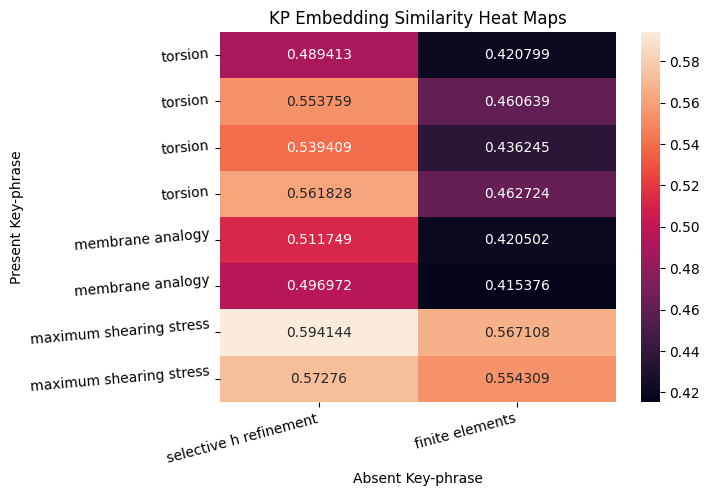

Input Tokens:  ['[CLS]', 'r', '##ns', 'mon', '##t', '##go', '##mer', '##y', 'multi', '##plication', 'algorithm', 'for', 'du', '##plicate', 'processing', 'of', 'base', 'transformation', 's', '.', 'this', 'paper', 'proposes', 'a', 'new', 'algorithm', 'to', 'achieve', 'about', 'two', 'times', 'speed', '##up', 'of', 'modular', 'ex', '##po', '##nent', '##iation', 'which', 'is', 'implemented', 'by', 'mon', '##t', '##go', '##mer', '##y', 'multi', '##plication', 'based', 'on', 'residue', 'number', 'systems', '(', 'r', '##ns', ')', '.', 'in', 'r', '##ns', 'mon', '##t', '##go', '##mer', '##y', 'multi', '##plication', ',', 'its', 'performance', 'is', 'determined', 'by', 'two', 'base', 'transformation', 's', 'dominant', '##ly', '.', 'for', 'the', 'purpose', 'of', 'realizing', 'parallel', 'processing', 'of', 'these', 'base', 'transformation', 's', ',', 'i', '.', 'e', '.', 'du', '##plicate', 'processing', ',', 'we', 'present', 'two', 'procedures', 'of', 'r', '##ns', 'mon', '##t', '##go', '##mer', '#

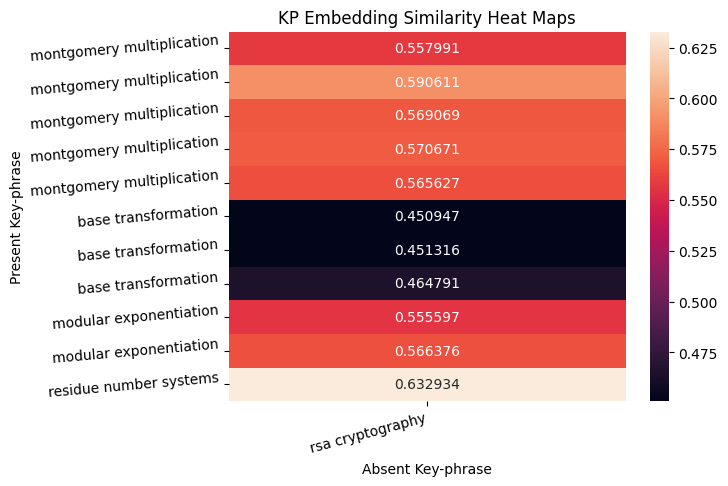

Input Tokens:  ['[CLS]', 'from', 'quality', 'in', 'use', 'to', 'value', 'in', 'the', 'world', '.', 'this', 'paper', 'argues', 'that', 'a', 'focus', 'on', 'quality', 'in', 'use', 'limits', 'the', 'potential', 'of', 'h', '##ci', '.', 'it', 'sum', '##mar', '##izes', 'how', 'novel', 'approaches', 'such', 'as', 'grounded', 'design', 'can', 'let', 'us', 'go', 'beyond', 'us', '##ability', 'to', 'reveal', 'the', 'fit', 'between', 'design', 's', 'and', 'expected', 'contexts', 'of', 'use', '.', 'this', 'however', 'is', 'still', 'not', 'enough', '.', 'it', 'cannot', 'resolve', 'di', '##lemma', '##s', 'about', 'what', 'is', 'and', 'is', 'not', 'a', 'us', '##ability', 'problem', ',', 'or', 'when', 'fit', 'is', 'or', 'is', 'not', 'essential', '.', 'such', 'di', '##lemma', '##s', 'can', 'only', 'be', 'resolved', 'by', 'an', 'understanding', 'of', 'the', 'value', 'that', 'artifacts', 'aim', 'to', 'deliver', 'in', 'the', 'world', '.', 'h', '##ci', 'must', 'move', 'beyond', 'context', '##ual', 'descript

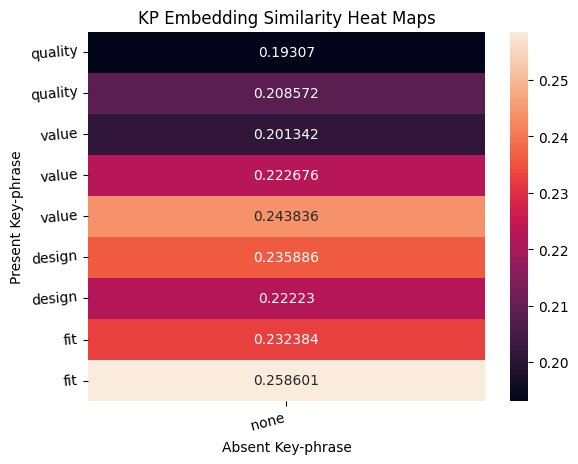

Input Tokens:  ['[CLS]', 'comparative', 'study', 'of', 'family', '2', 'g', '##p', '##c', '##rs', 'in', 'f', '##ug', '##u', 'rub', '##rip', '##es', '.', 'abstract', 'in', 'this', 'study', ',', 'members', 'of', 'family', '2', 'g', '##p', '##c', '##rs', ',', 'one', 'of', 'the', 'largest', 'families', 'of', 'receptors', 'in', 've', '##rte', '##bra', '##tes', ',', 'were', 'isolated', 'and', 'characterized', 'in', 'the', 'genome', 'of', 'the', 'j', '##apa', '##nese', 'pu', '##ffer', '##fish', ',', 'f', '##ug', '##u', 'rub', '##rip', '##es', ',', 'and', 'compared', 'with', 'the', 'or', '##th', '##olo', '##go', '##us', 'genes', 'in', 'other', 've', '##rte', '##bra', '##tes', '.', 'phylogenetic', 'analysis', 'carried', 'out', 'with', 'all', 've', '##rte', '##bra', '##te', 'family', '2', 'g', '##p', '##c', '##r', 'members', 'indicated', 'that', 'ca', '##l', '##r', 'c', '##g', '##rp', '##r', 'and', 'c', '##rf', 'are', 'the', 'most', 'diver', '##gent', 'receptor', 'group', 'within', 'this', 'famil

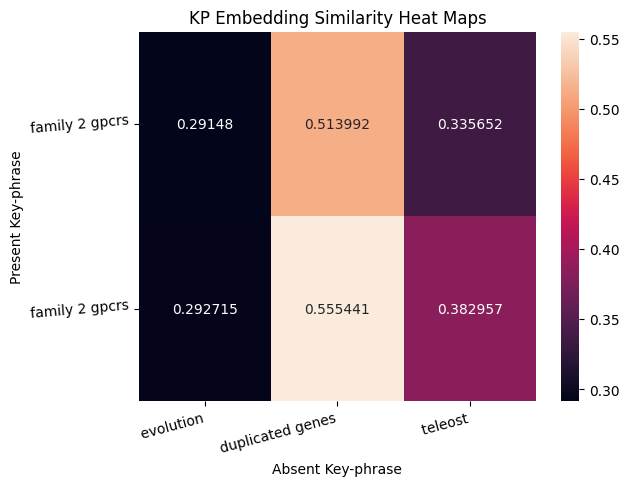

Input Tokens:  ['[CLS]', 'b', '##lot', '##to', 'game', 'based', 'low', 'complexity', 'fair', 'multi', '##user', 'sub', '##car', '##rier', 'allocation', 'for', 'up', '##link', 'of', '##d', '##ma', 'networks', '.', 'this', 'article', 'presents', 'a', 'sub', '##car', '##rier', 'allocation', 'scheme', 'based', 'on', 'a', 'b', '##lot', '##to', 'game', '(', 'sa', '##b', '##g', ')', 'for', 'or', '##th', '##ogo', '##nal', 'frequency', 'division', 'multiple', 'access', '(', 'of', '##d', '##ma', ')', 'networks', 'where', 'correlation', 'between', 'adjacent', 'sub', '##car', '##rier', '##s', 'is', 'considered', '.', 'in', 'the', 'proposed', 'game', ',', 'users', 'simultaneously', 'compete', 'for', 'sub', '##car', '##rier', '##s', 'using', 'a', 'limited', 'budget', '.', 'in', 'order', 'to', 'win', 'as', 'many', 'good', 'sub', '##car', '##rier', '##s', 'as', 'possible', 'in', 'this', 'game', ',', 'users', 'are', 'required', 'to', 'wise', '##ly', 'all', '##oc', '##ate', 'their', 'budget', '.', 'effi

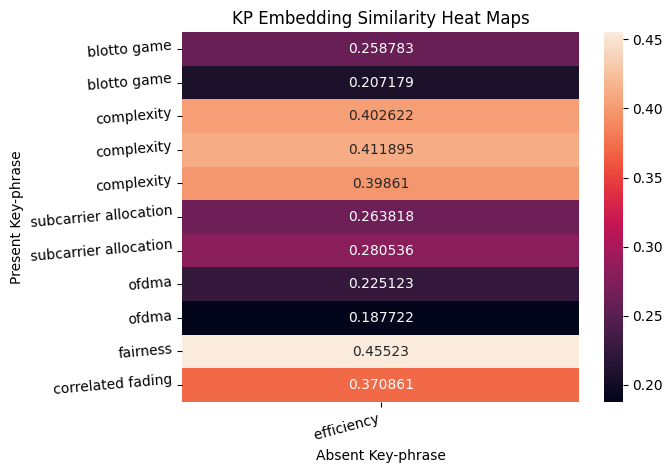

Input Tokens:  ['[CLS]', 'polymer', '##ization', 'conditions', 'influence', 'on', 'the', 'the', '##rm', '##ome', '##chan', '##ical', 'and', 'die', '##lect', '##ric', 'properties', 'of', 'un', '##sat', '##ura', '##ted', 'p', '##oly', '##ester', '##sty', '##rene', 'cop', '##oly', '##mers', '.', 'the', 'influence', 'of', 'different', 'polymer', '##ization', 'conditions', 'like', 'cu', '##ring', 'agent', '(', 'me', '##k', '##p', ')', 'amount', 'and', 's', '##ty', '##rene', 'content', 'on', 'the', 'glass', 'transition', 'temperature', ',', 'the', 'relative', 'die', '##lect', '##ric', 'constant', 'as', 'well', 'as', 'loss', 'factors', 'of', 'un', '##sat', '##ura', '##ted', 'p', '##oly', '##ester', '##sty', '##rene', 'polymer', 'systems', 'after', 'solid', '##ification', 'was', 'investigated', 'in', 'depth', '.', 'with', 'respect', 'to', 'a', 'high', 'average', 'molecular', 'mass', 'and', 'v', '##icker', '##s', 'hardness', 'a', 'cu', '##ring', 'agent', 'content', 'of', '3', '##w', '##t', 'is'

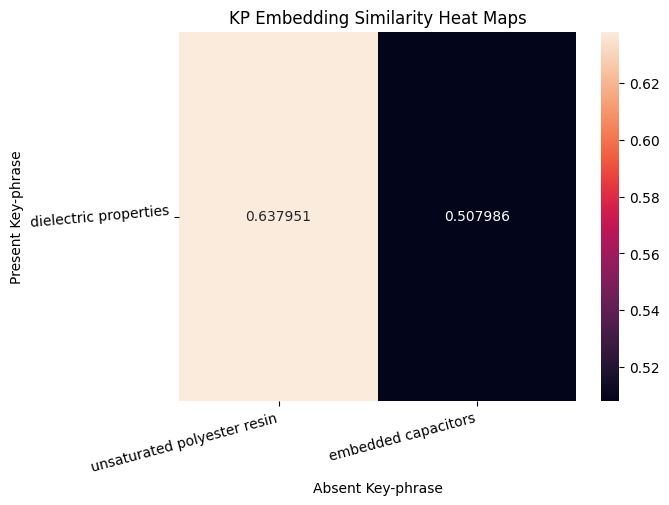

Input Tokens:  ['[CLS]', 'an', 'integration', 'of', 'online', 'and', 'pseudo', 'online', 'information', 'for', 'cu', '##rs', '##ive', 'word', 'recognition', '.', 'in', 'this', 'paper', ',', 'we', 'present', 'a', 'novel', 'method', 'to', 'extract', 'stroke', 'order', 'independent', 'information', 'from', 'online', 'data', '.', 'this', 'information', ',', 'which', 'we', 'term', 'pseudo', 'online', ',', 'convey', '##s', 'relevant', 'information', 'on', 'the', 'off', '##line', 'representation', 'of', 'the', 'word', '.', 'based', 'on', 'this', 'information', ',', 'a', 'combination', 'of', 'classification', 'decisions', 'from', 'online', 'and', 'pseudo', 'online', 'cu', '##rs', '##ive', 'word', 'recognize', '##rs', 'is', 'performed', 'to', 'improve', 'the', 'recognition', 'of', 'online', 'cu', '##rs', '##ive', 'words', '.', 'one', 'of', 'the', 'most', 'valuable', 'aspects', 'of', 'this', 'approach', 'with', 'respect', 'to', 'similar', 'methods', 'that', 'combine', 'online', 'and', 'off', '##

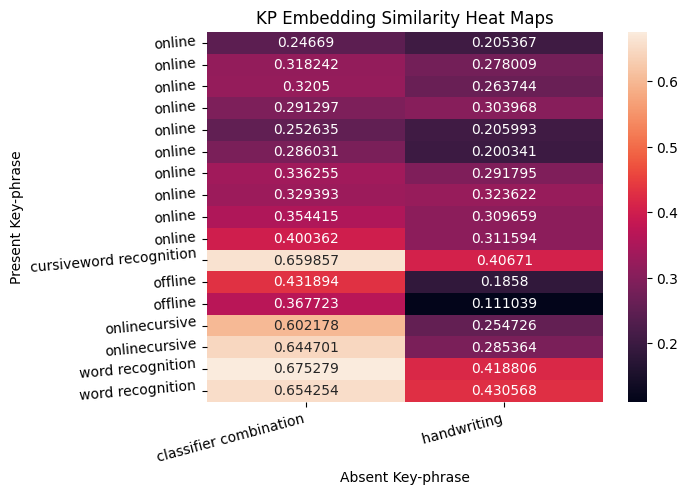

Input Tokens:  ['[CLS]', 'generation', 'of', 'quasi', 'g', '##aus', '##sian', 'pulse', 's', 'based', 'on', 'correlation', 'techniques', '.', 'the', 'g', '##aus', '##sian', 'pulse', 's', 'have', 'been', 'mostly', 'used', 'within', 'communications', ',', 'where', 'some', 'applications', 'can', 'be', 'emphasized', 'mobile', 'te', '##le', '##phony', '(', 'g', '##sm', ')', ',', 'where', 'g', '##ms', '##k', 'signals', 'are', 'used', ',', 'as', 'well', 'as', 'the', 'u', '##w', '##b', 'communications', ',', 'where', 'short', 'period', 'pulses', 'based', 'on', 'g', '##aus', '##sian', 'wave', '##form', 'are', 'generated', '.', 'since', 'the', 'g', '##aus', '##sian', 'function', 'sign', '##ifies', 'a', 'theoretical', 'concept', ',', 'which', 'cannot', 'be', 'accomplished', 'from', 'the', 'physical', 'point', 'of', 'view', ',', 'this', 'should', 'be', 'expressed', 'by', 'using', 'various', 'functions', ',', 'able', 'to', 'determine', 'physical', 'implementation', '##s', '.', 'new', 'techniques', '

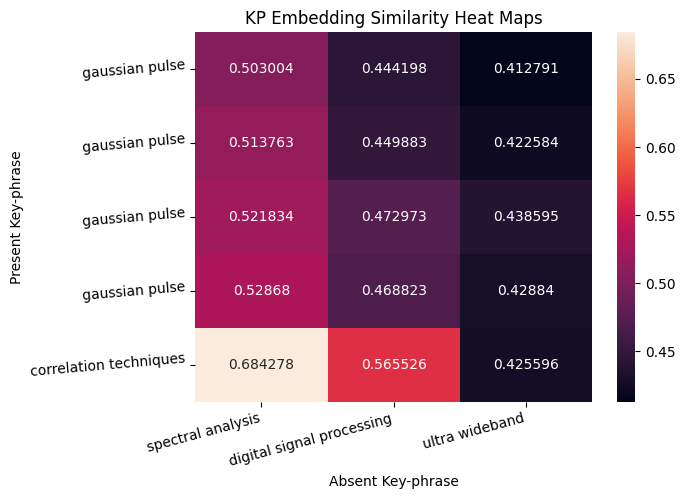

Input Tokens:  ['[CLS]', 'learning', 'linear', 'p', '##ca', 'with', 'convex', 'semi', 'definite', 'programming', '.', 'the', 'aim', 'of', 'this', 'paper', 'is', 'to', 'learn', 'a', 'linear', 'principal', 'component', 'using', 'the', 'nature', 'of', 'support', 'vector', 'machines', '(', 's', '##v', '##ms', ')', '.', 'to', 'this', 'end', ',', 'a', 'complete', 's', '##v', '##m', 'like', 'framework', 'of', 'linear', 'p', '##ca', '(', 's', '##v', '##p', '##ca', ')', 'for', 'deciding', 'the', 'projection', 'direction', 'is', 'constructed', ',', 'where', 'new', 'expected', 'risk', 'and', 'margin', 'are', 'introduced', '.', 'within', 'this', 'framework', ',', 'a', 'new', 'semi', 'definite', 'programming', 'problem', 'for', 'ma', '##xi', '##mizing', 'the', 'margin', 'is', 'formulated', 'and', 'a', 'new', 'definition', 'of', 'support', 'vectors', 'is', 'established', '.', 'as', 'a', 'weighted', 'case', 'of', 'regular', 'p', '##ca', ',', 'our', 's', '##v', '##p', '##ca', 'coincide', '##s', 'with'

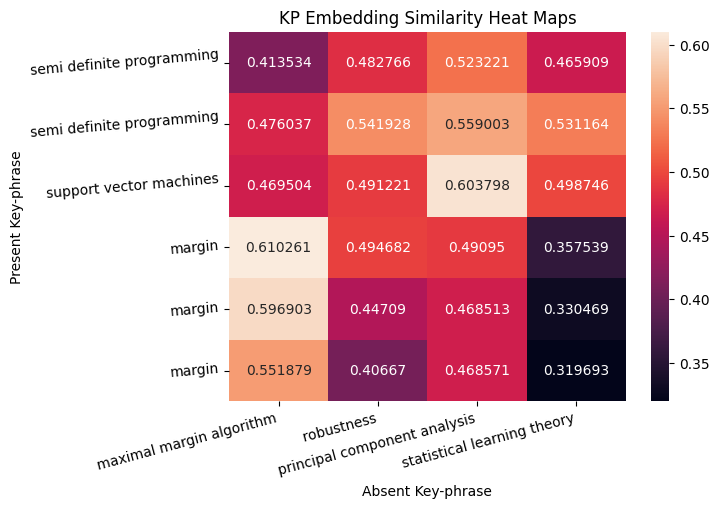

Input Tokens:  ['[CLS]', 'the', 'neighborhood', 'audit', '##ing', 'tool', 'a', 'hybrid', 'interface', 'for', 'audit', '##ing', 'the', 'um', '##ls', '.', 'the', 'um', '##ls', "'", 's', 'integration', 'of', 'more', 'than', '<', 'digit', '>', 'source', 'v', '##oc', '##ab', '##ular', '##ies', ',', 'not', 'necessarily', 'consistent', 'with', 'one', 'another', ',', 'causes', 'some', 'in', '##con', '##sist', '##encies', '.', 'the', 'purpose', 'of', 'audit', '##ing', 'the', 'um', '##ls', 'is', 'to', 'detect', 'such', 'in', '##con', '##sist', '##encies', 'and', 'to', 'suggest', 'how', 'to', 'resolve', 'them', 'while', 'observing', 'the', 'requirement', 'of', 'fully', 'representing', 'the', 'content', 'of', 'each', 'source', 'in', 'the', 'um', '##ls', '.', 'a', 'software', 'tool', ',', 'called', 'the', 'neighborhood', 'audit', '##ing', 'tool', '(', 'na', '##t', ')', ',', 'that', 'facilitate', '##s', 'um', '##ls', 'audit', '##ing', 'is', 'presented', '.', 'the', 'na', '##t', 'supports', 'neighbor

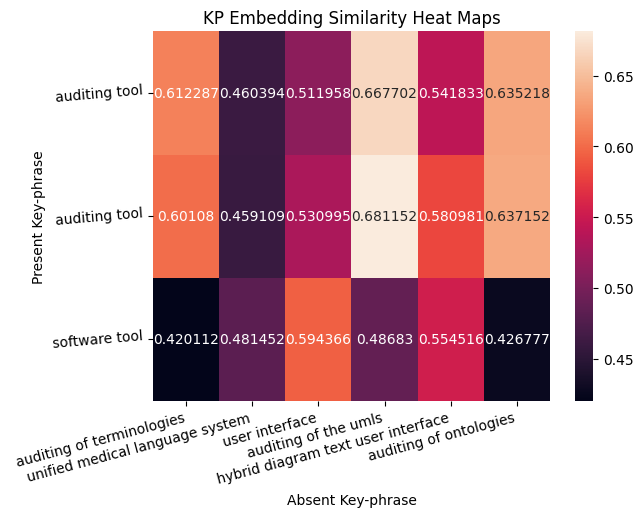

Input Tokens:  ['[CLS]', 'exclusion', 'region', 's', 'for', 'optimization', 'problems', '.', 'branch', 'and', 'bound', 'methods', 'for', 'finding', 'all', 'solutions', 'of', 'a', 'global', 'optimization', 'problem', 'in', 'a', 'box', 'frequently', 'have', 'the', 'difficulty', 'that', 'sub', '##box', '##es', 'containing', 'no', 'solution', 'cannot', 'be', 'easily', 'eliminated', 'if', 'they', 'are', 'close', 'to', 'the', 'global', 'minimum', '.', 'this', 'has', 'the', 'effect', 'that', 'near', 'each', 'global', 'minimum', ',', 'and', 'in', 'the', 'process', 'of', 'solving', 'the', 'problem', 'also', 'near', 'the', 'currently', 'best', 'found', 'local', 'minimum', ',', 'many', 'small', 'boxes', 'are', 'created', 'by', 'repeated', 'splitting', ',', 'whose', 'processing', 'often', 'dominate', '##s', 'the', 'total', 'work', 'spent', 'on', 'the', 'global', 'search', '.', 'this', 'paper', 'discusses', 'the', 'reasons', 'for', 'the', 'occurrence', 'of', 'this', 'so', 'called', 'cluster', 'effe

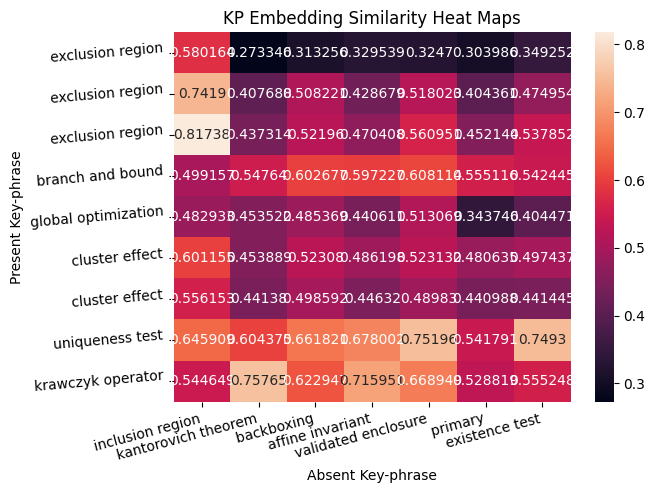

In [32]:
import torch
from sklearn.metrics.pairwise import cosine_similarity
import itertools
import seaborn as sns
import matplotlib.pyplot as plt     
import numpy as np
    
# from torchmetrics.functional import pairwise_cosine_similarity
def cosine_sim(a,b, dim=2, eps=1e-08):
    # Given that cos_sim(u, v) = dot(u, v) / (norm(u) * norm(v))
    #                          = dot(u / norm(u), v / norm(v))
    # We fist normalize the rows, before computing their dot products via transposition:
    # where None is specified, it unsqueezes a dimension there, 
    # its used here to enable broadcasting to divide every element
    # of that vector by its norm
    a_n, b_n = a.norm(dim=dim)[:,:,None], b.norm(dim=dim)[:,:,None]
    a_norm, b_norm = a / torch.clamp(a_n, min=eps), b / torch.clamp(b_n, min=eps)
    # a (bs,var_a,768) , b (bs,var_a,768)
    res = torch.matmul(a_norm,torch.permute(b_norm, (0,-1,-2)))
    return res


def plot_sim(cm, x_list, y_list):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
    
    # labels, title and ticks
    ax.set_xlabel('Absent Key-phrase');ax.set_ylabel('Present Key-phrase'); 
    ax.set_title('KP Embedding Similarity Heat Maps');
    ax.xaxis.set_ticklabels(x_list); ax.yaxis.set_ticklabels(y_list);
    # rotate x axis and y axis labels to 30 degrees to prevent overlap
    plt.setp(ax.get_yticklabels(), rotation=5, horizontalalignment='right')
    plt.setp(ax.get_xticklabels(), rotation=15, horizontalalignment='right')
    plt.show()
    
with torch.no_grad():
    for line_ind, tokens in enumerate(all_inp_tokens):
        # input_ids
        tok_ids = torch.tensor(tokenizer.convert_tokens_to_ids(tokens))
        # token_type_ids
        token_type_ids = torch.tensor([0 for _ in range(len(tokens))])
        # attention_mask
        attention_mask = torch.tensor([1 for _ in range(len(tokens))])
        inp_dict = {
            'input_ids': tok_ids.unsqueeze(dim=0), # add batch dim
            'token_type_ids': token_type_ids.unsqueeze(dim=0),
            'attention_mask': attention_mask.unsqueeze(dim=0)
        }
        model_out = model(**inp_dict)
        # last hidden state
        embs = model_out['last_hidden_state']
        # print('model_out shape: ',embs.shape)

        # break
        ex_kp = all_ex_kps[line_ind]
        ab_kp = all_ab_kps[line_ind]
        # all extractive and abstractive key-phrase embeddings including duplicate positions
        ekp_embs, akp_embs = [], []
        
        ex_tokens, ab_tokens = [], []
        for kp_e in ex_kp:
            for (s1, e1) in ex_kp[kp_e]:
                ex_tokens.append(kp_e)
                extracted_emb = embs[:,s1:e1,:]
                # print(extracted_emb.shape, start, end, len(lines[line_ind].split(" "))+2)
                mean_emb_e = torch.mean(extracted_emb, dim=1)
                ekp_embs.append(mean_emb_e)
                
        for kp_a in ab_kp:
            for (s2, e2) in ab_kp[kp_a]:
                ab_tokens.append(kp_a)
                abstracted_emb = embs[:,s2:e2,:]
                mean_emb_a = torch.mean(abstracted_emb, dim=1)
                akp_embs.append(mean_emb_a)
                
        
        # print(ex_tokens, ab_tokens)
        # ex_ab_tokenpairs = itertools.product(ex_tokens, ab_tokens)
        
        # compute cosine similarity
        if not len(ekp_embs) or not akp_embs:
            continue
        ekp_embs = torch.stack(ekp_embs, dim=1)
        akp_embs = torch.stack(akp_embs, dim=1)
        cos_sim = cosine_sim(ekp_embs, akp_embs)
        # print('cos_sim shape: ',cos_sim.shape)
        
        # print(cos_sim)
        print('Input Tokens: ',tokens)
        # plot
        plot_sim(cm = cos_sim.squeeze(0).numpy(),
                 x_list = ab_tokens,
                 y_list = ex_tokens)
        
        # verify with sklearn
        # print(cosine_similarity(kp_embs.squeeze(0), kp_embs.squeeze(0)))
        if line_ind == 30:
            break